# YOLOv8 Architecture: Built from Scratch

This notebook presents a simple implementation of the **YOLOv8 (You Only Look Once, Version 8)** object detection architecture from scratch. YOLOv8 is a state-of-the-art, real-time object detection model that emphasizes speed and accuracy, using an anchor-free approach and improved backbone and head designs from its previous versions.

---

###  Contributors:

- **Pranay Gadh** – Delhi Technological University (DTU)  
- **Divansu Mishra** – Delhi Technological University (DTU)  
- **Aarushi Anand** – Delhi Technological University (DTU)  

---

This implementation aims to provide educational insights into the core building blocks of YOLOv8 while allowing for customization and experimentation in research and applied settings.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yolo-data/yolo_data/_annotations.csv
/kaggle/input/yolo-data/yolo_data/import os.py
/kaggle/input/yolo-data/yolo_data/labels/12_mp4-0_jpg.rf.13768a6bc89343d1f3a551945edea8ed.txt
/kaggle/input/yolo-data/yolo_data/labels/5_mp4-7_jpg.rf.8624d28bb3c29c80ec9283fdab5f19e8.txt
/kaggle/input/yolo-data/yolo_data/labels/11_mp4-10_jpg.rf.4700be742c709d3ebbac02e5f323cd12.txt
/kaggle/input/yolo-data/yolo_data/labels/2_mp4-8_jpg.rf.25c000e17a6f603a228386f9780e87a1.txt
/kaggle/input/yolo-data/yolo_data/labels/10_mp4-41_jpg.rf.4dee909f4a5f9be3f96de326a0d087e0.txt
/kaggle/input/yolo-data/yolo_data/labels/5_mp4-14_jpg.rf.00ee0a5c6158d66128aded7ba6c5e3c2.txt
/kaggle/input/yolo-data/yolo_data/labels/test2_mp4-4_jpg.rf.a20b7a6e45f87da6fb6a63f76ec8130d.txt
/kaggle/input/yolo-data/yolo_data/labels/test_mp4-4_jpg.rf.c92ba4917bf77f870bd07eeac79fdfb1.txt
/kaggle/input/yolo-data/yolo_data/labels/15_mp4-8_jpg.rf.c12aa7b103f55effa7a163a438e2e007.txt
/kaggle/input/yolo-data/yolo_data/labels/10_mp4-28_

In [2]:
import torch
import torch.nn as nn

## Step 1: ConvBNAct Block
Converts our input image (B, 3,640,640) into (B,64, 320,320)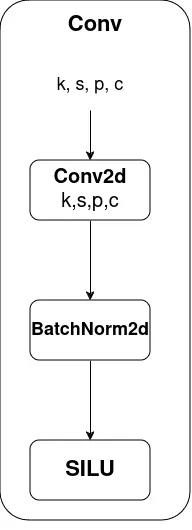
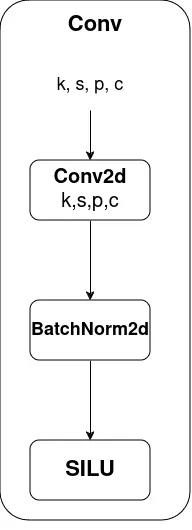

In [3]:
class ConvBNAct (nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride,padding, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.SiLU())
    def forward(self, x):
        return self.block(x)

In [4]:
#image_test
from PIL import Image
from torchvision import transforms

image = Image.open("/kaggle/input/traffic-data/traffic_wala_dataset/train/images/10_mp4-10_jpg.rf.b87509668caff369c5501325477e6d9a.jpg").convert("RGB")
transf = transforms.Compose([
    transforms.ToTensor(),
])
image_tensor = transf(image).unsqueeze(0)

In [5]:
model = ConvBNAct(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 2, padding = 1)
output = model(image_tensor)
output.shape

torch.Size([1, 64, 320, 320])

## Step2: BottleNeck Block:
Extracts importat features from our image
<br>
Input:  (B, 64, 320, 320) -->
        1×1 conv → (B, 32, 320, 320)-->
        3×3 conv → (B, 64, 320, 320)-->
<br>
Residual: if allowed --> out = out + input
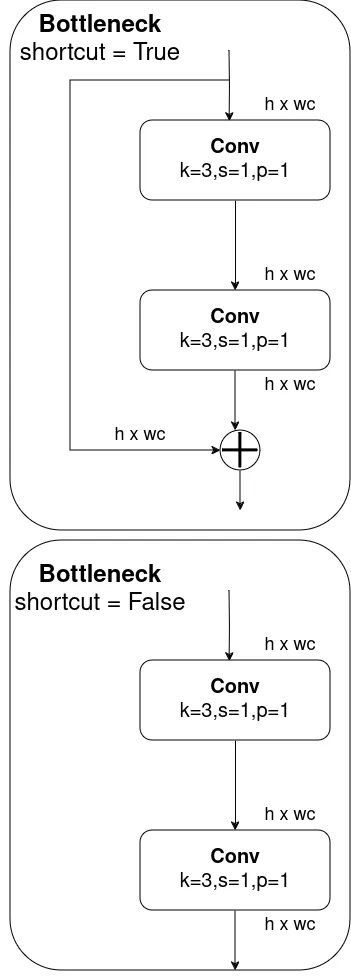
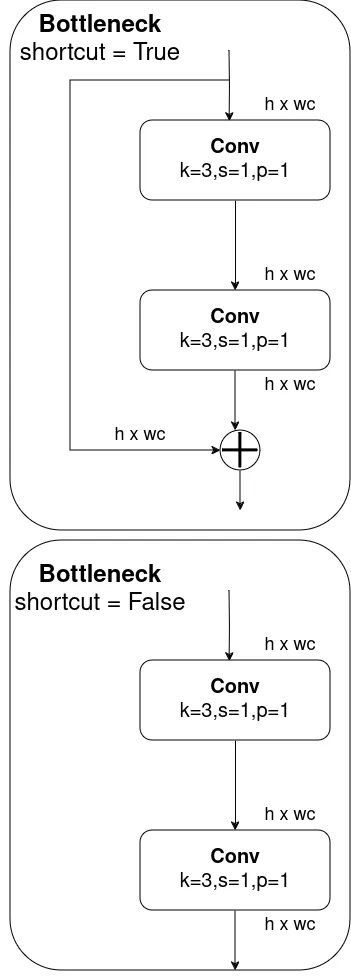

In [6]:
class Bottleneck(nn.Module):
    def __init__ (self, in_channels, out_channels, shortcut = True, expansion = 0.5):
        super().__init__()
        hidden_channels = int(out_channels * expansion)
        self.conv1 = ConvBNAct(in_channels, hidden_channels, stride = 1, padding = 0,kernel_size = 1)
        self.conv2 = ConvBNAct(hidden_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        self.residual = shortcut and (in_channels == out_channels)

    def forward(self,x):
        out = self.conv2(self.conv1(x))
        if (self.residual == True):
            out = out + x
        return out

In [7]:
model2 = Bottleneck(in_channels = 64, out_channels = 64)
output2 = model2(output)
output2.shape

torch.Size([1, 64, 320, 320])

## C2f Block:
C2f = "Concatenate → Convolution → f-block (like Bottleneck)"
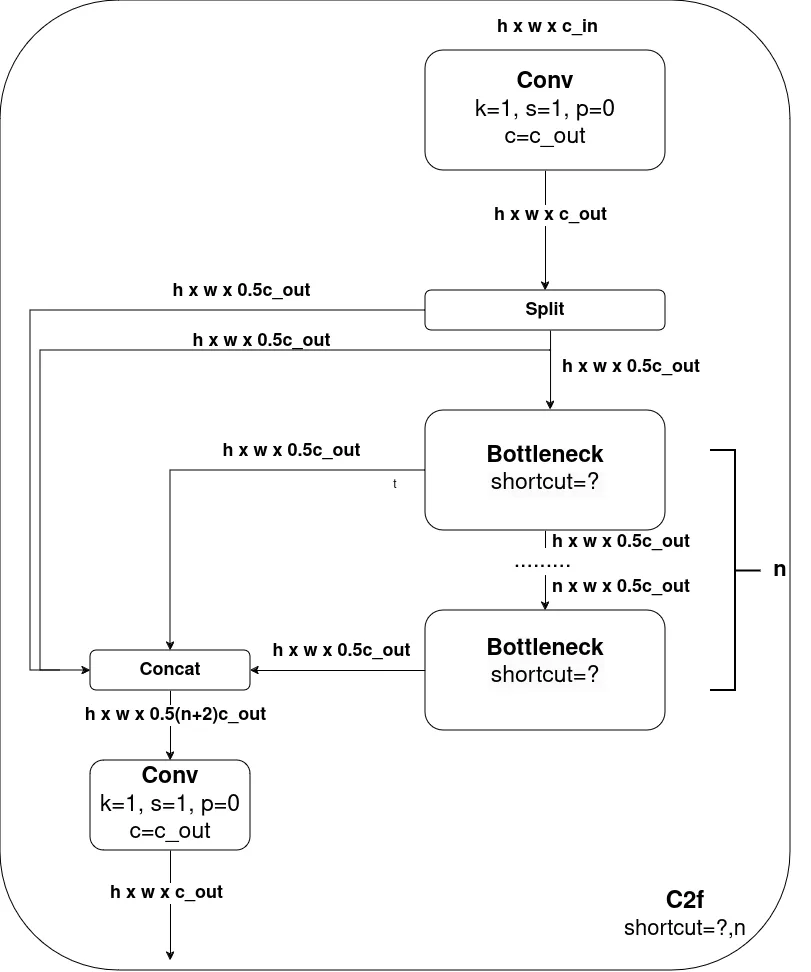
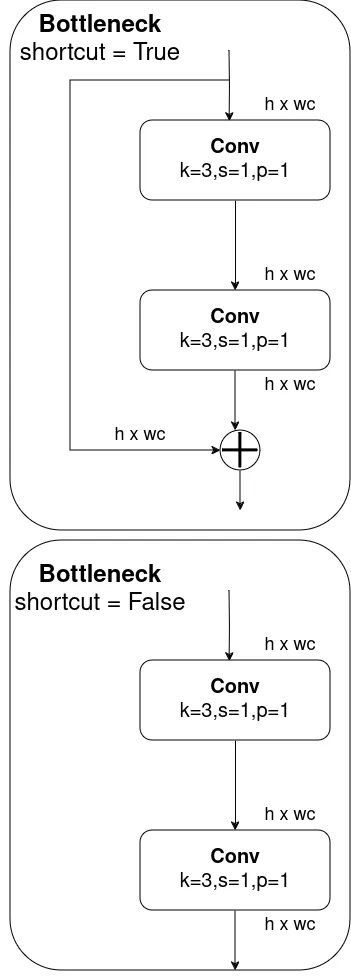
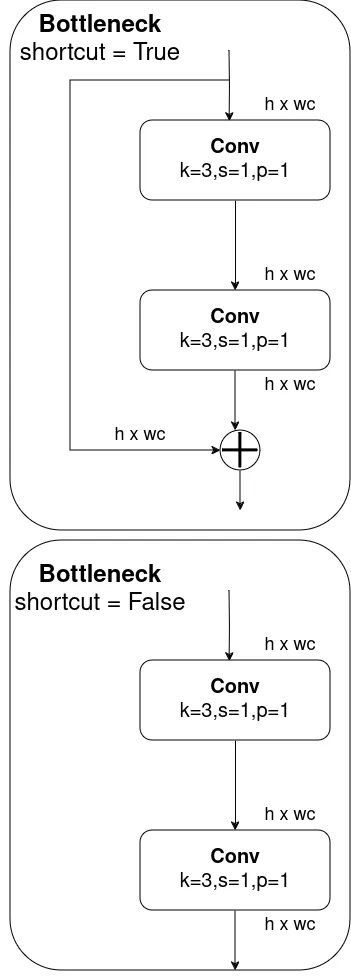
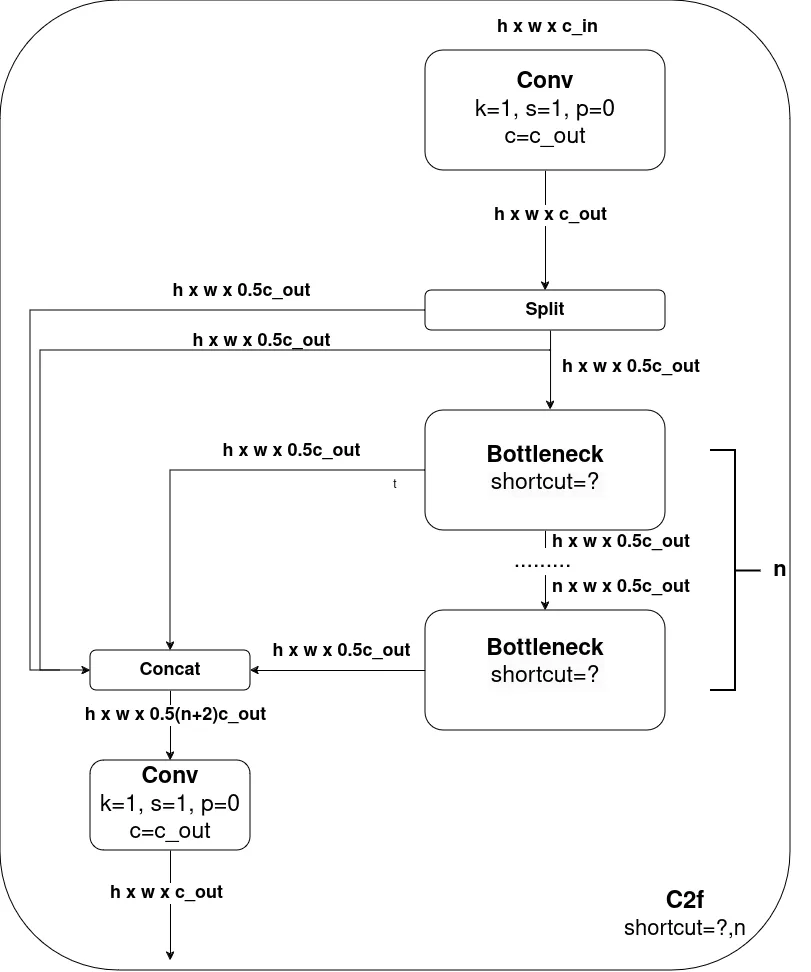

In [8]:
class c2f(nn.Module):
    def __init__ (self, in_channels, out_channels, n, d,expansion = 0.5, shortcut = True):
        super().__init__()
        hidden_channels = int(out_channels * expansion)
        num_bnecks = max(round(n * d), 1)
        #1. applying 1st conv layer from ConvBNAct
        self.conv1 = ConvBNAct(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0)
        #2. splitting this output in 2 parts:
        #   one for passing into bottlenecks and other as it is (for skip connections behaviour)
        self.layers = nn.ModuleList([
            Bottleneck(hidden_channels, hidden_channels) for i in range(num_bnecks)
        ])
        #3. applying second conv layer
        self.conv2 = ConvBNAct((num_bnecks + 2)*hidden_channels, out_channels, kernel_size = 1, stride = 1, padding = 0)

    def forward(self, x):
        #1. Input Image -->CONV1 LAYER --> increased channels wali image
        x = self.conv1(x)
        #2. splitting this obtained image into 2 parts channel-wise
        x1 = x[:, :x.shape[1]//2, :, :]   # shape: B, 64, 320, 320
        x2 = x[:, x.shape[1]//2:, :, :]   # shape: B, 64, 320, 320

        outputs = [x1,x2]
        # now we let remain x1 as it is, and pass x2 into bottle necks
        for layer in self.layers:
            x1 = layer(x1)
            outputs.append(x1)

        out_final = torch.concat(outputs, dim = 1) # dim = 1 for concatinating along channels

        #3. now, we pass this concatinated output into conv2 layer
        out = self.conv2(out_final)
        return out

        #What's actually done:
        """
        we took input (B,64,320,320), passed it in conv1 layer, got (B,128,320,320)

        now, we splitted x into x1 and x2

        we already had x1 and x2 in outputs[] list each of which is (B,64,320,320)
        now we add bottle-necked x1s also num_bneck times, so now our outputs[] list
        contains [x1, x2, num_bnecks times modified x1s] and this is why we did
        (num_bnecks + 2) in conv2 layer

        now we concatenate all these elemnts of list along the channels,
        let's say we take 3 bottle necks,
        so in output list, we have x1 and x2 (64 channels each)
        and 3 more modified x1s (64 channels each)
        concatinating them, we get 320 channels
        now, these 320 channels --> CONV2 LAYER --> output_channels = 128

        SO, AT LAST WE GET A 128-channel IMAGE!!
        """

# Just some testing....

In [9]:
from PIL import Image
from torchvision import transforms
image = Image.open("/kaggle/input/traffic-data/traffic_wala_dataset/train/images/10_mp4-10_jpg.rf.b87509668caff369c5501325477e6d9a.jpg").convert("RGB")
transform = transforms.Compose([
    transforms.ToTensor(),
])
image = transform(image).unsqueeze(0)

In [10]:
# image.shape

In [11]:
step1 = ConvBNAct(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 2, padding = 1)
image2 = step1(image)
image2.shape

torch.Size([1, 64, 320, 320])

In [12]:
step2 = Bottleneck(in_channels = 64, out_channels = 64)
image3 = step2(image2)
image3.shape

torch.Size([1, 64, 320, 320])

In [13]:
step3 = c2f(in_channels = 64, out_channels = 128, n = 3, d = 1)
image4 = step3(image3)
image4.shape

torch.Size([1, 128, 320, 320])

## Spatial Pyramid Pooling Fast (SPPF) Block:
Take features from different "scales" and combine them, so that the network becomes better at capturing both local and global features
<br>
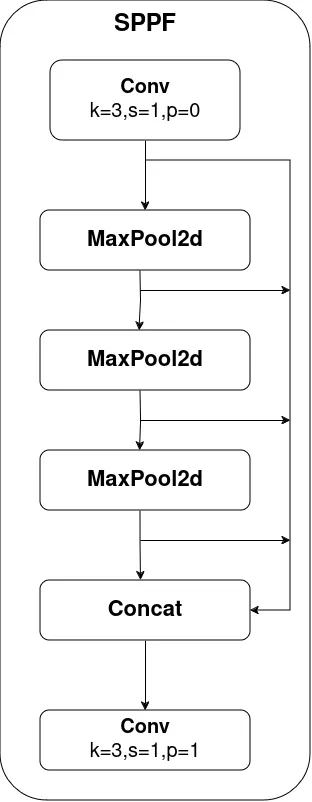
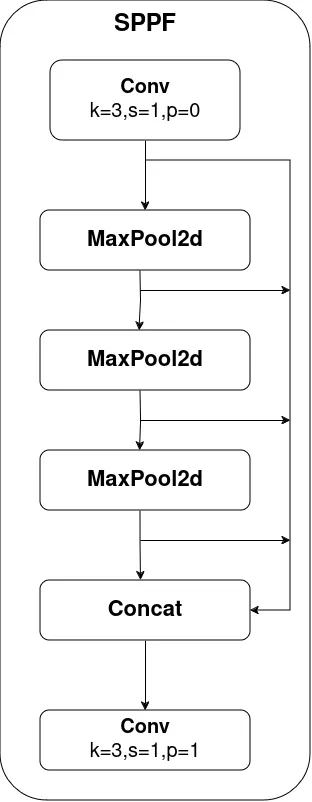

In [14]:
class sppf(nn.Module):
    def __init__ (self, in_channels, out_channels, expansion = 0.5,num_pool = 3):
        super().__init__()
        hidden_channels = int(out_channels * expansion)
        #1. 1 x 1 convolution
        #128 channels --> 64 channels (to reduce the computation)
        self.conv1 = ConvBNAct(in_channels, hidden_channels, kernel_size = 1, stride = 1, padding = 0)

        #2. Max-Pooling
        self.poolLayer = nn.ModuleList([
            nn.MaxPool2d(kernel_size = 5, stride = 1, padding = 2) for i in range(num_pool)
        ])

        #3. 1 x 1 Convolution
        #restoring back the desired number of channels...
        self.conv2 = ConvBNAct((num_pool + 1)*hidden_channels, out_channels, stride = 1, kernel_size = 1, padding = 0)

    def forward(self,x):
        x = self.conv1(x)
        outs = [x]

        for layer in self.poolLayer:
            y1 = layer(x)
            outs.append(y1)
        x_cat = torch.concat(outs, dim = 1)

        out = self.conv2(x_cat)
        #print(x_cat.shape)
        return out

In [15]:
step4 = sppf(in_channels = 128, out_channels = 128, num_pool = 5)
image5 = step4(image4)
image5.shape

torch.Size([1, 128, 320, 320])

## Putting it Together :- The BACKBONE 
The backbone is the feature extractor of the model - it takes in the input image and extracts feature maps at multiple scales (from low-level to high-level). These features are then passed to the neck and head for detection.
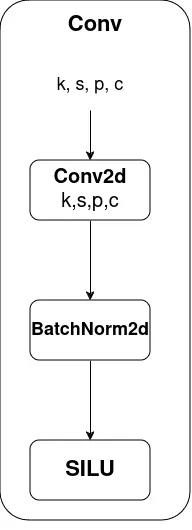
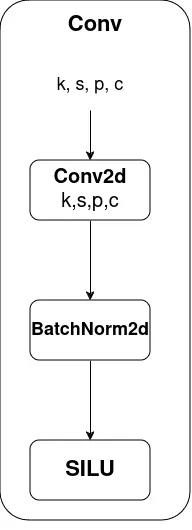

In [16]:
class Backbone(nn.Module):
    def __init__(self, depth_mul = 1, width_mul = 1):
        super().__init__()

        def ch(c):
            return max(int(c * float(width_mul)), 1)

        def d(n):
            return max(round(n * float(depth_mul)), 1)

        # Stage-0: Initial Conv layer (P1)
        self.stem = ConvBNAct(3, ch(64), 3, 2, 1)

        # P2
        self.conv1 = ConvBNAct(ch(64), ch(128), 3, 2, 1)
        self.stage1 = c2f(ch(128), ch(128), n=d(3), d=1)

        # P3
        self.conv2 = ConvBNAct(ch(128), ch(256), 3, 2, 1)
        self.stage2 = c2f(ch(256), ch(256), n=d(6), d=1)

        # P4
        self.conv3 = ConvBNAct(ch(256), ch(512), 3, 2, 1)
        self.stage3 = c2f(ch(512), ch(512), n=d(6), d=1)

        # P5
        self.conv4 = ConvBNAct(ch(512), ch(512), 3, 2, 1)
        self.stage4 = c2f(ch(512), ch(512), n=d(3), d=1)

        # SPPF
        self.sppf = sppf(in_channels=ch(512), out_channels=ch(512), num_pool=3)

        #Sequential Layer
        self.FinalLayer = nn.Sequential(
            self.stem,self.conv1, self.stage1,self.conv2, self.stage2,self.conv3, self.stage3,self.conv4, self.stage4,
            self.sppf
        )

        #x1-layer
        self.x1_layer = nn.Sequential(
            self.stem,self.conv1, self.stage1,self.conv2, self.stage2
        )
        #x2-layer
        self.x2_layer = nn.Sequential(
            self.stem,self.conv1, self.stage1,self.conv2, self.stage2,self.conv3, self.stage3
        )
        #x3-layer
        self.x3_layer = nn.Sequential(
            self.stem,self.conv1, self.stage1,self.conv2, self.stage2,self.conv3, self.stage3,self.conv4, self.stage4,
            self.sppf
        )
    def forward(self, x):
        out = self.FinalLayer(x)
        x1 = self.x1_layer(x)
        x2 = self.x2_layer(x)
        x3 = self.x3_layer(x)
        return out,x1, x2, x3

In [17]:
FinalStep = Backbone()
out, x1, x2, x3 = FinalStep(image)

In [18]:
print(f"========Inputs for Neck Layer are======== \nx1 with shape: {x1.shape},\nx2 with shape: {x2.shape} and\nx3 with shape: {x3.shape}")

========Inputs for Neck Layer are======== 
x1 with shape: torch.Size([1, 256, 80, 80]),
x2 with shape: torch.Size([1, 512, 40, 40]) and
x3 with shape: torch.Size([1, 512, 20, 20])


In [19]:
print(f"{sum(p.numel() for p in FinalStep.parameters())/1e6} million parameters")

10.699904 million parameters


## NECK Architecture
![image.png](attachment:d7db4410-160c-4d59-8c41-57e7e5ffaf26.png)

In [20]:
class upsample(nn.Module):
    def __init__(self, scale_factor = 2, mode = "nearest"):
        super().__init__()
        self.Upsample = nn.Upsample(scale_factor = scale_factor, mode = mode)

    def forward(self, x):
        return self.Upsample(x)

### Testing....

In [21]:
# up = upsample()
# u_img = up(x3)
# u_img.shape

In [22]:
class Neck(nn.Module):
    def __init__(self):
        super().__init__()
        self.upsample = upsample(scale_factor=2, mode="nearest")

        #12 C2f
        self.c2f12 = c2f(in_channels = 1024, out_channels = 1024, n = 3, d = 1, shortcut = False)

        #15 C2f
        self.c2f15 = c2f(in_channels = 768, out_channels = 768, n = 3, d = 1, shortcut = False)

        #downsample:
        self.down1 = ConvBNAct(in_channels = 768, out_channels = 256, kernel_size = 1, stride = 1, padding = 0)

        #16 conv
        self.conv16 = ConvBNAct(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 2, padding = 1)

        #18 c2f
        self.c2f18 = c2f(in_channels = 768, out_channels = 768, n = 3, d = 1, shortcut = False)

        #down
        self.down2 = ConvBNAct(in_channels = 768, out_channels = 512, kernel_size = 1, stride = 1, padding = 0)

        #19 conv
        self.conv19 = ConvBNAct(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 2, padding = 1)

        #21 c2f
        self.c2f21 = c2f(in_channels = 1024, out_channels = 1024, n = 3, d = 1, shortcut = False)

        #down
        self.down3 = ConvBNAct(in_channels = 1024, out_channels = 512, kernel_size = 1, stride = 1, padding = 0)
        self.down4 = ConvBNAct(in_channels = 1024, out_channels = 512, kernel_size = 1, stride = 1, padding = 0)

    def forward(self, x1, x2, x3):

        #10 upsample
        x_10 = self.upsample(x3)

        #11 Concat
        x_11 = torch.concat([x_10, x2], dim = 1)

        #12 c2f
        x_12 = self.down4(self.c2f12(x_11))

        #13 upsample
        x_13 = self.upsample(x_12)

        #14 concat
        x_14 = torch.concat([x_13, x1], dim = 1)

        #15 c2f
        x_15 = self.c2f15(x_14)
        detect_1 = self.down1(x_15)

        x_16 = self.conv16(detect_1)

        #17 Concat
        x_17 = torch.concat([x_12, x_16], dim = 1)

        #18
        x_18 = self.c2f18(x_17)
        detect_2 = self.down2(x_18)
        
        #19 conv
        x_19 = self.conv19(detect_2)

        #20Concat
        x_20 = torch.concat([x3, x_19], dim = 1)

        #21 c2f
        x_21 = self.c2f21(x_20)
        detect_3 = self.down3(x_21)
        return detect_1, detect_2, detect_3

In [23]:
neck_out = Neck()
detect_1, detect_2, detect_3 = neck_out(x1, x2, x3)

print(f"========Outputs for Neck Layer are======== \n"
      f"detect_1 with shape: {detect_1.shape},\n"
      f"detect_2 with shape: {detect_2.shape},\n"
      f"detect_3 with shape: {detect_3.shape}")

========Outputs for Neck Layer are======== 
detect_1 with shape: torch.Size([1, 256, 80, 80]),
detect_2 with shape: torch.Size([1, 512, 40, 40]),
detect_3 with shape: torch.Size([1, 512, 20, 20])


## The DETECT Box

In [24]:
class Detect(nn.Module):
    def __init__(self, in_channels, num_classes = 1, reg_max = 15):
        super().__init__()
        self.reg_max = reg_max
        self.num_classes = num_classes

        self.bbox_layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size = 3, padding = 1),
            nn.SiLU(),
            nn.Conv2d(in_channels, in_channels, kernel_size = 3, padding = 1),
            nn.SiLU(),
            nn.Conv2d(in_channels, 4*(reg_max+1), kernel_size = 1, padding = 0)
        )

        self.class_layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size = 3, padding = 1),
            nn.SiLU(),
            nn.Conv2d(in_channels, in_channels, kernel_size = 3, padding = 1),
            nn.SiLU(),
            nn.Conv2d(in_channels, num_classes, kernel_size = 1, padding = 0)
        )

    def forward(self, x):
        bounding_box = self.bbox_layer(x)
        classif_box = self.class_layer(x)

        return bounding_box, classif_box

In [25]:
# print(f"{sum(p.numel() for p in neck_out.parameters())/1e6} million parameters")

In [26]:
class Head(nn.Module):
    def __init__(self, in_channels_list, num_classes = 1, reg_max = 15):
        super().__init__()
        self.head_layer = nn.ModuleList([
            Detect(in_channels, num_classes, reg_max) for in_channels in in_channels_list
            
        ])

    def forward(self, features):
        all_preds = []
        for i, feat in enumerate(features):
            bbox_pred, cls_pred = self.head_layer[i](feat)
            all_preds.append((bbox_pred, cls_pred))
        return all_preds

In [27]:
head = Head(in_channels_list=[256,512,512], num_classes=1, reg_max=15)

detects = [detect_1, detect_2, detect_3]
outputs = head(detects)

for i, (bbox, cls) in enumerate(outputs):
    print(f"Scale {i+1}: BBox shape = {bbox.shape}, Cls shape = {cls.shape}")

Scale 1: BBox shape = torch.Size([1, 64, 80, 80]), Cls shape = torch.Size([1, 1, 80, 80])
Scale 2: BBox shape = torch.Size([1, 64, 40, 40]), Cls shape = torch.Size([1, 1, 40, 40])
Scale 3: BBox shape = torch.Size([1, 64, 20, 20]), Cls shape = torch.Size([1, 1, 20, 20])


## Putting it together: The YOLOv8 Architecture

In [28]:
import torch.nn as nn

class YOLOv8(nn.Module):
    def __init__(self, backbone, neck, head):
        super(YOLOv8, self).__init__()
        self.backbone = backbone
        self.neck = neck
        self.head = head

    def forward(self, x):
        # x: input image tensor (B, 3, H, W)
        _, x1, x2, x3 = self.backbone(x)         # Get features from backbone
        d1, d2, d3 = self.neck(x1, x2, x3)       # Neck processing
        preds = self.head([d1, d2, d3])          # Head predictions
        return preds                             # [(bbox1, cls1), (bbox2, cls2), (bbox3, cls3)]

In [29]:
backbone = Backbone()
neck = Neck()  
head = Head(in_channels_list=[256, 512, 512], num_classes=1, reg_max=15)
model = YOLOv8(backbone, neck, head).to(device="cuda")

### Just some model testing...

In [30]:
import torch

dummy_input = torch.randn(1, 3, 640, 640).to("cuda")

with torch.no_grad():
    outputs = model(dummy_input)

for i, (bbox, cls) in enumerate(outputs):
    print(f"Scale {i+1}:")
    print(f" - BBox shape: {bbox.shape}") 
    print(f" - Cls shape:  {cls.shape}")   

Scale 1:
 - BBox shape: torch.Size([1, 64, 80, 80])
 - Cls shape:  torch.Size([1, 1, 80, 80])
Scale 2:
 - BBox shape: torch.Size([1, 64, 40, 40])
 - Cls shape:  torch.Size([1, 1, 40, 40])
Scale 3:
 - BBox shape: torch.Size([1, 64, 20, 20])
 - Cls shape:  torch.Size([1, 1, 20, 20])


In [31]:
import torch
import torch.nn.functional as F

def decode_bboxes(bbox_pred, stride, reg_max=15):
    
    B, _, H, W = bbox_pred.shape
    # Reshape to [B, 4, reg_max+1, H, W]
    bbox_pred = bbox_pred.view(B, 4, reg_max + 1, H, W)

    # Softmax over distribution bins
    prob = F.softmax(bbox_pred, dim=2)

    # Get expected value via projection
    proj = torch.arange(reg_max + 1, dtype=prob.dtype, device=prob.device)
    dist = (prob * proj[None, None, :, None, None]).sum(dim=2)  # [B, 4, H, W]

    # Make grid of anchor centers
    grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    grid = torch.stack((grid_x, grid_y), dim=0).to(bbox_pred.device)  # [2, H, W]

    # Convert to image scale
    x_center = (grid[0][None] + 0.5) * stride
    y_center = (grid[1][None] + 0.5) * stride

    # dist = [left, top, right, bottom]
    x1 = x_center - dist[:, 0] * stride
    y1 = y_center - dist[:, 1] * stride
    x2 = x_center + dist[:, 2] * stride
    y2 = y_center + dist[:, 3] * stride

    xc = (x1 + x2) / 2
    yc = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1

    bboxes = torch.stack([xc, yc, w, h], dim=-1) 
    return bboxes.view(B, -1, 4)


In [32]:
import torch
import torch.nn.functional as F

def process_cls_scores(cls_pred, score_thresh=0.4):
    """
    Process classification predictions for 1-class model.

    Args:
        cls_pred: Tensor of shape [B, 1, H, W]
        score_thresh: minimum score to keep a prediction

    Returns:
        score_mask: Boolean mask [B, H*W]
        scores: Confidence scores [B, H*W]
    """
    B, C, H, W = cls_pred.shape
    assert C == 1, "Only supports 1 class"

    # Apply sigmoid to get confidence scores
    probs = torch.sigmoid(cls_pred)  
    probs = probs.view(B, -1)        

    # Create a boolean mask for scores above threshold
    score_mask = probs > score_thresh 
    
    return score_mask, probs

In [33]:
import torch

def get_final_predictions(preds, strides=[8, 16, 32], score_thresh=0.4):
    
    all_boxes = []
    for i, (bbox_pred, cls_pred) in enumerate(preds):
        stride = strides[i]
        boxes = decode_bboxes(bbox_pred, stride=stride)
        conf_mask, confs = process_cls_scores(cls_pred, score_thresh=score_thresh)

        # FIXED: Handle batch dimension correctly
        for batch_idx in range(boxes.shape[0]):
            batch_boxes = boxes[batch_idx]  # [H*W, 4]
            batch_mask = conf_mask[batch_idx]  # [H*W]
            batch_confs = confs[batch_idx]  # [H*W]
            
            # Filter valid predictions for this batch
            valid_boxes = batch_boxes[batch_mask]
            valid_scores = batch_confs[batch_mask]

            for j in range(valid_boxes.size(0)):
                x, y, w, h = valid_boxes[j]
                score = valid_scores[j].item()
                all_boxes.append((x.item(), y.item(), w.item(), h.item(), score))

    return all_boxes
def xywh2xyxy(x):
    
    y = x.clone() if isinstance(x, torch.Tensor) else torch.tensor(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # x1
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # y1  
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # x2
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # y2
    return y

def decode_from_distr(pred, reg_max=15):
    
    B, channels, H, W = pred.shape
    pred = pred.view(B, 4, reg_max + 1, H, W)
    
    # Apply softmax
    prob = F.softmax(pred, dim=2)
    
    # Create projection weights
    proj = torch.arange(reg_max + 1, dtype=prob.dtype, device=prob.device)
    
    # Calculate expected values
    exp = torch.sum(prob * proj[None, None, :, None, None], dim=2)
    
    # Generate grid coordinates
    grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    grid = torch.stack((grid_x, grid_y), dim=0).to(pred.device)
    
    # Decode to xyxy format (simplified version)
    decoded = exp.view(B, 4, -1).permute(0, 2, 1)  # [B, H*W, 4]
    return decoded

def get_dfl_targets(boxes, reg_max=15):
    
    B, N, _ = boxes.shape
    targets = torch.zeros(B, N, 4, reg_max + 1, device=boxes.device)
    return targets

In [34]:
model.eval()
with torch.no_grad():
    img = torch.randn(1, 3, 640, 640).to("cuda")  # dummy image
    preds = model(img)

final_boxes = get_final_predictions(preds, score_thresh=0.4)

# Print results
for i, (x, y, w, h, score) in enumerate(final_boxes[:5]):
    print(f"Box {i+1}: [x={x:.1f}, y={y:.1f}, w={w:.1f}, h={h:.1f}] | score={score:.2f}")

Box 1: [x=4.0, y=4.1, w=120.0, h=119.3] | score=0.49
Box 2: [x=12.0, y=4.1, w=120.0, h=119.3] | score=0.49
Box 3: [x=20.0, y=4.1, w=120.0, h=119.3] | score=0.49
Box 4: [x=28.0, y=4.1, w=120.0, h=119.3] | score=0.49
Box 5: [x=36.0, y=4.1, w=120.0, h=119.3] | score=0.49


### Non-Max Suppression

In [35]:
import torchvision.ops as ops

def apply_nms(boxes, scores, iou_threshold=0.5):
    """
    Applies Non-Maximum Suppression to filter overlapping boxes.

    Args:
        boxes: Tensor of shape (N, 4) in [x_center, y_center, w, h]
        scores: Tensor of shape (N,)
        iou_threshold: IoU threshold for suppression

    Returns:
        kept_indices: Tensor of indices of boxes kept after NMS
    """
    if boxes.numel() == 0:
        return torch.tensor([], dtype=torch.int64)

    # Convert [xc, yc, w, h] → [x1, y1, x2, y2]
    x1 = boxes[:, 0] - boxes[:, 2] / 2
    y1 = boxes[:, 1] - boxes[:, 3] / 2
    x2 = boxes[:, 0] + boxes[:, 2] / 2
    y2 = boxes[:, 1] + boxes[:, 3] / 2
    boxes_xyxy = torch.stack([x1, y1, x2, y2], dim=1)

    keep = ops.nms(boxes_xyxy, scores, iou_threshold=iou_threshold)
    return keep

In [36]:
# Convert to tensors
boxes = torch.tensor([b[:4] for b in final_boxes]).to("cuda")
scores = torch.tensor([b[4] for b in final_boxes]).to("cuda")

# Apply NMS
keep_indices = apply_nms(boxes, scores, iou_threshold=0.5)

# Print filtered boxes
print("After NMS:")
for i in keep_indices[:10]:
    x, y, w, h = boxes[i]
    score = scores[i]
    print(f"Box: [x={x:.1f}, y={y:.1f}, w={w:.1f}, h={h:.1f}] | score={score:.2f}")

After NMS:
Box: [x=624.2, y=624.6, w=478.8, h=476.5] | score=0.51
Box: [x=624.2, y=48.6, w=478.8, h=476.5] | score=0.51
Box: [x=624.2, y=208.6, w=478.8, h=476.5] | score=0.51
Box: [x=624.2, y=368.6, w=478.8, h=476.5] | score=0.51
Box: [x=48.2, y=624.6, w=478.8, h=476.5] | score=0.50
Box: [x=208.2, y=624.6, w=478.8, h=476.5] | score=0.50
Box: [x=368.2, y=624.6, w=478.8, h=476.5] | score=0.50
Box: [x=48.2, y=112.6, w=478.8, h=476.5] | score=0.50
Box: [x=48.2, y=272.6, w=478.8, h=476.5] | score=0.50
Box: [x=48.2, y=432.6, w=478.8, h=476.5] | score=0.50


In [37]:
import os
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import torch

class YOLODataset(Dataset):
    def __init__(self, images_dir, labels_dir, img_size=640):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.img_size = img_size

        self.image_files = sorted([
            f for f in os.listdir(images_dir)
            if f.endswith(('.jpg', '.png', '.jpeg'))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_file)
        label_path = os.path.join(self.labels_dir, os.path.splitext(img_file)[0] + ".txt")

        # Load image
        img = Image.open(img_path).convert("RGB").resize((self.img_size, self.img_size))
        img = np.array(img).astype(np.float32) / 255.0
        img_tensor = torch.tensor(img).permute(2, 0, 1)  # (C, H, W)

        # Load label (class_id cx cy w h)
        boxes = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    cls, cx, cy, w, h = map(float, line.strip().split())
                    boxes.append([cls, cx, cy, w, h])
        boxes = torch.tensor(boxes, dtype=torch.float32)

        return img_tensor, boxes

In [38]:
def create_datasets():
    train_images = "/kaggle/input/traffic-data/traffic_wala_dataset/train/images"
    train_labels = "/kaggle/input/traffic-data/traffic_wala_dataset/train/labels"
    val_images = "/kaggle/input/traffic-data/traffic_wala_dataset/valid/images"
    val_labels = "/kaggle/input/traffic-data/traffic_wala_dataset/valid/labels"

    train_ds = YOLODataset(train_images, train_labels)
    val_ds = YOLODataset(val_images, val_labels)

    return train_ds, val_ds

In [39]:
train_dataset, val_dataset = create_datasets()
print(f"Loaded {len(train_dataset)} training images and {len(val_dataset)} validation images.")

# Try loading one sample:
img, boxes = train_dataset[0]
print("Image shape:", img.shape)
print("Boxes:", boxes)

Loaded 536 training images and 90 validation images.
Image shape: torch.Size([3, 640, 640])
Boxes: tensor([[0.0000, 0.1336, 0.7797, 0.1375, 0.1945],
        [0.0000, 0.3625, 0.7188, 0.1273, 0.2070],
        [0.0000, 0.5391, 0.9563, 0.1656, 0.0875],
        [0.0000, 0.1344, 0.5953, 0.1375, 0.2438],
        [0.0000, 0.2945, 0.5609, 0.0844, 0.1219],
        [0.0000, 0.2758, 0.3320, 0.0594, 0.0867],
        [0.0000, 0.2203, 0.2516, 0.0594, 0.1047],
        [0.0000, 0.2875, 0.1570, 0.0773, 0.1547],
        [0.0000, 0.2055, 0.1344, 0.0891, 0.1852],
        [0.0000, 0.3688, 0.2117, 0.0461, 0.0648],
        [0.0000, 0.6805, 0.3273, 0.0672, 0.0867],
        [0.0000, 0.8984, 0.4180, 0.0781, 0.1109],
        [0.0000, 0.7312, 0.2180, 0.0477, 0.0773],
        [0.0000, 0.6477, 0.2516, 0.0594, 0.0836],
        [0.0000, 0.6586, 0.1656, 0.0500, 0.0664],
        [0.0000, 0.6727, 0.1000, 0.0359, 0.0586],
        [0.0000, 0.7242, 0.0820, 0.0445, 0.0984],
        [0.0000, 0.7953, 0.0664, 0.0539, 0.1172],
 

In [40]:
def collate_fn(batch):
    images = []
    targets = []

    for img, target in batch:
        images.append(img)
        targets.append(target)

    images = torch.stack(images, dim=0)  # Stack images (fixed size)
    return images, targets               # Keep targets as list (variable size)

In [41]:
from torch.utils.data import DataLoader


BATCH_SIZE = 2
NUM_WORKERS = 0 

# Create DataLoaders for training and validation
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn
)


for batch in train_loader:
    images, targets = batch
    print("Dataloader working:")
    print("Images shape:", images.shape)
    print("Targets length (batch):", len(targets))
    print("Target sample shape:", targets[0].shape)
    break

Dataloader working:
Images shape: torch.Size([2, 3, 640, 640])
Targets length (batch): 2
Target sample shape: torch.Size([13, 5])


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        ce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p_t = targets * probs + (1 - targets) * (1 - probs)
        loss = ce_loss * ((1 - p_t) ** self.gamma)

        if self.alpha >= 0:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss *= alpha_t

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

In [43]:
class DistributionFocalLoss(nn.Module):
    def __init__(self, reg_max=15):
        super().__init__()
        self.reg_max = reg_max

    def forward(self, pred, target):
        # FIXED: Added clamping to prevent index overflow
        dis_left = target.long()
        dis_right = torch.clamp(dis_left + 1, max=self.reg_max)

        weight_right = target - dis_left
        weight_left = 1 - weight_right

        pred = pred.log_softmax(dim=-1)
        loss_left = F.nll_loss(pred.view(-1, pred.shape[-1]), dis_left.view(-1), reduction='none')
        loss_right = F.nll_loss(pred.view(-1, pred.shape[-1]), dis_right.view(-1), reduction='none')

        loss = (weight_left.view(-1) * loss_left + weight_right.view(-1) * loss_right).view(target.shape)
        return loss.mean()

In [44]:
def bbox_iou(box1, box2, eps=1e-7):
    # box: [x1, y1, x2, y2]
    x1 = torch.max(box1[:, 0], box2[:, 0])
    y1 = torch.max(box1[:, 1], box2[:, 1])
    x2 = torch.min(box1[:, 2], box2[:, 2])
    y2 = torch.min(box1[:, 3], box2[:, 3])

    inter = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    union = area1 + area2 - inter + eps
    iou = inter / union
    return iou

In [45]:
def preprocess_targets(targets, batch_size, device, image_size=640):
    """Convert YOLO format targets to [x1, y1, x2, y2] in pixel coordinates."""
    max_objects = max(len(t) for t in targets) if targets and any(len(t) > 0 for t in targets) else 1

    gt_labels = torch.zeros(batch_size, max_objects, 1, device=device)
    gt_bboxes = torch.zeros(batch_size, max_objects, 4, device=device)
    mask_gt = torch.zeros(batch_size, max_objects, 1, device=device)

    for i, target in enumerate(targets):
        if len(target) > 0:
            target = target.to(device)

            
            xywh = target[:, 1:5].clone()
            xywh[:, 0] *= image_size  # cx
            xywh[:, 1] *= image_size  # cy
            xywh[:, 2] *= image_size  # w
            xywh[:, 3] *= image_size  # h

            
            x1 = xywh[:, 0:1] - xywh[:, 2:3] / 2
            y1 = xywh[:, 1:2] - xywh[:, 3:4] / 2
            x2 = xywh[:, 0:1] + xywh[:, 2:3] / 2
            y2 = xywh[:, 1:2] + xywh[:, 3:4] / 2
            xyxy = torch.cat([x1, y1, x2, y2], dim=1)

            gt_labels[i, :len(target), 0] = target[:, 0]
            gt_bboxes[i, :len(target)] = xyxy
            mask_gt[i, :len(target), 0] = 1

    return gt_labels, gt_bboxes, mask_gt

In [46]:
def bbox_ciou_loss(pred_boxes, target_boxes, eps=1e-7):
    """
    pred_boxes, target_boxes: [N, 4] in xyxy format
    """
    x1 = torch.max(pred_boxes[:, 0], target_boxes[:, 0])
    y1 = torch.max(pred_boxes[:, 1], target_boxes[:, 1])
    x2 = torch.min(pred_boxes[:, 2], target_boxes[:, 2])
    y2 = torch.min(pred_boxes[:, 3], target_boxes[:, 3])

    inter = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)
    area_pred = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    area_target = (target_boxes[:, 2] - target_boxes[:, 0]) * (target_boxes[:, 3] - target_boxes[:, 1])
    union = area_pred + area_target - inter + eps
    iou = inter / union

    # Center distance
    px = (pred_boxes[:, 0] + pred_boxes[:, 2]) / 2
    py = (pred_boxes[:, 1] + pred_boxes[:, 3]) / 2
    gx = (target_boxes[:, 0] + target_boxes[:, 2]) / 2
    gy = (target_boxes[:, 1] + target_boxes[:, 3]) / 2
    center_dist = (px - gx) ** 2 + (py - gy) ** 2

    # Enclosing box diagonal
    x1_c = torch.min(pred_boxes[:, 0], target_boxes[:, 0])
    y1_c = torch.min(pred_boxes[:, 1], target_boxes[:, 1])
    x2_c = torch.max(pred_boxes[:, 2], target_boxes[:, 2])
    y2_c = torch.max(pred_boxes[:, 3], target_boxes[:, 3])
    diagonal = ((x2_c - x1_c) ** 2 + (y2_c - y1_c) ** 2) + eps

    ciou = iou - (center_dist / diagonal)
    loss = 1.0 - ciou.clamp(min=-1.0, max=1.0)
    return loss.mean()

In [47]:
def make_anchors(feats, strides):
    """Generate anchor points."""
    anchor_points, stride_tensor = [], []

    for i, stride in enumerate(strides):
        h, w = feats[i].shape[2:]
        y, x = torch.arange(h, dtype=torch.float32), torch.arange(w, dtype=torch.float32)
        yv, xv = torch.meshgrid(y, x, indexing='ij')

        grid = torch.stack([xv, yv], 2).view(-1, 2)
        anchor_points.append(grid * stride + stride / 2)
        stride_tensor.append(torch.full((grid.shape[0], 1), stride, dtype=torch.float32))

    anchor_points = torch.cat(anchor_points, 0).to(feats[0].device)
    stride_tensor = torch.cat(stride_tensor, 0).to(feats[0].device)

    return anchor_points, stride_tensor

def decode_bboxes_dfl(bbox_pred, anchor_points, stride_tensor, reg_max=15):
    """Decode bbox predictions from DFL format."""
    batch_size, num_anchors, _ = bbox_pred.shape
    bbox_pred = bbox_pred.view(batch_size, num_anchors, 4, reg_max + 1)
    bbox_pred = F.softmax(bbox_pred, dim=-1)

    proj = torch.arange(reg_max + 1, dtype=bbox_pred.dtype, device=bbox_pred.device)
    bbox_pred = (bbox_pred * proj[None, None, None, :]).sum(dim=-1)

    lt, rb = bbox_pred.chunk(2, dim=-1)
    anchor_points = anchor_points[None].expand(batch_size, -1, -1)
    stride_tensor = stride_tensor[None].expand(batch_size, -1, -1)

    x1y1 = anchor_points - lt * stride_tensor
    x2y2 = anchor_points + rb * stride_tensor

    return torch.cat([x1y1, x2y2], dim=-1)

def process_predictions(outputs, strides=[8, 16, 32]):
    """Convert YOLOv8 outputs to loss-compatible format."""
    pred_scores_list, pred_bboxes_list, feats = [], [], []

    for (bbox_pred, cls_pred) in outputs:
        batch_size, _, h, w = cls_pred.shape
        cls_pred_flat = cls_pred.view(batch_size, -1, h * w).transpose(1, 2)
        bbox_pred_flat = bbox_pred.view(batch_size, -1, h * w).transpose(1, 2)

        pred_scores_list.append(cls_pred_flat)
        pred_bboxes_list.append(bbox_pred_flat)
        feats.append(cls_pred)

    pred_scores = torch.cat(pred_scores_list, dim=1)
    pred_bboxes_raw = torch.cat(pred_bboxes_list, dim=1)

    anchor_points, stride_tensor = make_anchors(feats, strides)
    pred_bboxes = decode_bboxes_dfl(pred_bboxes_raw, anchor_points, stride_tensor)

    return pred_scores, pred_bboxes, anchor_points, stride_tensor

In [48]:
class SimpleTaskAlignedAssigner(nn.Module):
    def __init__(self, topk=13, num_classes=1, alpha=1.0, beta=6.0):
        super().__init__()
        self.topk, self.alpha, self.beta = topk, alpha, beta
        self.num_classes = num_classes

    def compute_iou(self, pred_bboxes, gt_bboxes):
        pred_bboxes = pred_bboxes[:, None, :]  
        gt_bboxes = gt_bboxes[None, :, :]      

        lt = torch.max(pred_bboxes[..., :2], gt_bboxes[..., :2])
        rb = torch.min(pred_bboxes[..., 2:], gt_bboxes[..., 2:])

        wh = (rb - lt).clamp(min=0)
        inter = wh[..., 0] * wh[..., 1]

        pred_area = (pred_bboxes[..., 2] - pred_bboxes[..., 0]) * (pred_bboxes[..., 3] - pred_bboxes[..., 1])
        gt_area = (gt_bboxes[..., 2] - gt_bboxes[..., 0]) * (gt_bboxes[..., 3] - gt_bboxes[..., 1])

        union = pred_area + gt_area - inter
        iou = inter / (union + 1e-6)

        return iou

    def forward(self, pd_scores, pd_bboxes, anc_points, gt_labels, gt_bboxes, mask_gt):
        batch_size, num_anchors = pd_scores.shape[:2]
        device = pd_scores.device

        target_labels = torch.zeros(batch_size, num_anchors, dtype=torch.float, device=device)
        target_bboxes = torch.zeros(batch_size, num_anchors, 4, device=device)
        target_scores = torch.zeros(batch_size, num_anchors, self.num_classes, device=device)
        fg_mask = torch.zeros(batch_size, num_anchors, dtype=torch.bool, device=device)

        for b in range(batch_size):
            valid_gt = mask_gt[b].squeeze(-1).bool()
            num_gt = valid_gt.sum()

            if num_gt == 0:
                continue

            gt_labels_b = gt_labels[b][valid_gt].squeeze(-1)
            gt_bboxes_b = gt_bboxes[b][valid_gt]

            ious = self.compute_iou(pd_bboxes[b], gt_bboxes_b)
            cls_scores = pd_scores[b][:, gt_labels_b.long()]
            align_metric = cls_scores.sigmoid() ** self.alpha * ious ** self.beta

            topk_vals, topk_idxs = align_metric.topk(min(self.topk, num_anchors), dim=0)

            # Replace line 816-817 in SimpleTaskAlignedAssigner.forward()
            for gt_idx in range(num_gt):
                anchor_idxs = topk_idxs[:, gt_idx]
                for k, anchor_idx in enumerate(anchor_idxs):
                    fg_mask[b, anchor_idx] = True
                    target_labels[b, anchor_idx] = gt_labels_b[gt_idx]
                    target_bboxes[b, anchor_idx] = gt_bboxes_b[gt_idx]
            
                   
                    score_sum = topk_vals[:, gt_idx].sum()
                    norm_score = topk_vals[k, gt_idx] / (score_sum + 1e-6)
            
                    class_idx = int(gt_labels_b[gt_idx].item())
                    target_scores[b, anchor_idx, class_idx] = norm_score
            
                    class_idx = int(gt_labels_b[gt_idx].item())
                    target_scores[b, anchor_idx, class_idx] = topk_vals[k, gt_idx]

        return target_labels, target_bboxes, target_scores, fg_mask

In [49]:
def compute_val_loss(focal_loss, pred_scores, pred_bboxes, gt_labels, gt_bboxes, mask_gt):
    assigner = SimpleTaskAlignedAssigner(topk=10, num_classes=1)  # 🔧 Define it here

    _, target_bboxes, target_scores, fg_mask = assigner(
        pred_scores, pred_bboxes, None, gt_labels, gt_bboxes, mask_gt
    )

    if fg_mask.sum() > 0:
        cls_loss = focal_loss(pred_scores[fg_mask], target_scores[fg_mask])
        bbox_loss = 1.0 - bbox_iou(pred_bboxes[fg_mask], target_bboxes[fg_mask]).mean()
    else:
        background_targets = torch.zeros_like(pred_scores)
        cls_loss = focal_loss(pred_scores, background_targets) * 0.1
        bbox_loss = torch.tensor(0.0, device=pred_scores.device)

    return cls_loss, bbox_loss


In [50]:
def train(model, train_loader, val_loader, device, num_epochs=10, lr=1e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    focal_loss = FocalLoss()
    assigner = SimpleTaskAlignedAssigner(topk=10, num_classes=1)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_idx, (imgs, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            imgs = imgs.to(device)
            outputs = model(imgs)
            batch_size = imgs.shape[0]
        
            pred_scores, pred_bboxes, anchor_points, _ = process_predictions(outputs)
            gt_labels, gt_bboxes, mask_gt = preprocess_targets(targets, batch_size, device)
        
            _, target_bboxes, target_scores, fg_mask = assigner(
                pred_scores, pred_bboxes, anchor_points, gt_labels, gt_bboxes, mask_gt
            )
        
            # print(f"[DEBUG] Epoch {epoch+1}, Batch {batch_idx}:")
            # print(f"  - Matched foreground anchors: {fg_mask.sum().item()}")
            # print(f"  - GT boxes: {gt_bboxes[0][mask_gt[0].squeeze(-1).bool()]}")
            # print(f"  - Max pred score: {pred_scores.sigmoid().max().item():.4f}")

            print(f"[Epoch {epoch+1}] Foreground matches: {fg_mask.sum().item()} / {fg_mask.numel()} ({100 * fg_mask.sum().item() / fg_mask.numel():.2f}%)")

            # Compute loss
            if fg_mask.sum() > 0:
                cls_loss = focal_loss(pred_scores[fg_mask], target_scores[fg_mask])
                bbox_loss = 1.0 - bbox_iou(pred_bboxes[fg_mask], target_bboxes[fg_mask]).mean()
                bg_loss = focal_loss(pred_scores[~fg_mask], torch.zeros_like(pred_scores[~fg_mask])) * 0.1
                loss = cls_loss + bbox_loss + bg_loss  # Combined loss
            else:
                background_targets = torch.zeros_like(pred_scores)
                bg_weight = 0.1  # Reduced background loss weight
                bg_targets = torch.zeros_like(pred_scores)
                loss = focal_loss(pred_scores, torch.zeros_like(pred_scores)) * 0.1


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        val_loss = validate(model, val_loader, device, lambda *args: compute_val_loss(focal_loss, *args))

        print(f"Epoch {epoch+1}: Train Loss = {total_loss / len(train_loader):.4f} | Val Loss = {val_loss:.4f}")

    return model

In [51]:
@torch.no_grad()
def validate(model, val_loader, device, loss_fn):
    model.eval()
    total_cls_loss = 0.0
    total_box_loss = 0.0
    total_samples = 0

    for images, targets in val_loader:
        images = images.to(device)
        batch_size = images.shape[0]
        outputs = model(images)

        # Step 1 & 2: Process preds and targets
        pred_scores, pred_bboxes, anchor_points, _ = process_predictions(outputs)
        gt_labels, gt_bboxes, mask_gt = preprocess_targets(targets, batch_size, device)

        # Compute losses
        cls_loss, bbox_loss = loss_fn(
            pred_scores, pred_bboxes, gt_labels, gt_bboxes, mask_gt
        )

        total_cls_loss += cls_loss.item() * batch_size
        total_box_loss += bbox_loss.item() * batch_size
        total_samples += batch_size

    avg_cls = total_cls_loss / total_samples
    avg_bbox = total_box_loss / total_samples
    avg_total = avg_cls + avg_bbox

    print(f"Validation Loss → Total: {avg_total:.4f}, CLS: {avg_cls:.4f}, BBOX: {avg_bbox:.4f}")
    return avg_total

In [53]:
from tqdm.notebook import tqdm

In [54]:
from tqdm.notebook import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader, 
    device=device,
    num_epochs=10,
    lr=1e-4
)

In [ ]:
# Save the full model (architecture + weights)
torch.save(model, "yolov8_custom_vehicle_1.pt")
print("Model saved as yolov8_custom_vehicle_1.pt")


In [ ]:
import torch
import cv2

# Load your trained model
model = torch.load("/kaggle/working/yolov8_custom_vehicle_1.pt", weights_only=False).eval().cuda()

# Load and preprocess image
img = cv2.imread("/kaggle/input/traffic-data/traffic_wala_dataset/valid/images/10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.jpg")[..., ::-1]  # replace with your image path
img_resized = cv2.resize(img, (640, 640)) / 255.0
img_tensor = torch.tensor(img_resized).permute(2, 0, 1).unsqueeze(0).float().cuda()

# Forward pass
with torch.no_grad():
    preds = model(img_tensor)

# Print classification confidence for each scale
for i, (bbox, cls) in enumerate(preds):
    print(f"Scale {i+1}:")
    print(f"  BBox Shape: {bbox.shape}")
    print(f"  Cls Shape : {cls.shape}")
    print(f"  Cls Max   : {cls.sigmoid().max().item():.4f}")
    print(f"  Cls Mean  : {cls.sigmoid().mean().item():.4f}")


In [ ]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np

def predict_yolo_labels(image_path, model, score_thresh=0.3, input_size=640, reg_max=15):
    """
    Run inference on a single image and return YOLO-format labels:
    Format: [class_id x_center y_center width height] (normalized to [0,1])
    """
    # Load and preprocess image
    img = cv2.imread(image_path)[..., ::-1]  # BGR to RGB
    orig_h, orig_w = img.shape[:2]
    img_resized = cv2.resize(img, (input_size, input_size)) / 255.0
    img_tensor = torch.tensor(img_resized).permute(2, 0, 1).unsqueeze(0).float().cuda()

    # Forward pass
    with torch.no_grad():
        preds = model(img_tensor)

    pred_boxes_all, pred_scores_all = [], []
    strides = [8, 16, 32]

    for i, (bbox_raw, cls_raw) in enumerate(preds):
        stride = strides[i]
        B, _, H, W = cls_raw.shape
        cls_conf = cls_raw.sigmoid().squeeze(0).flatten()  # [H*W]

        keep = cls_conf > score_thresh
        if keep.sum() == 0:
            continue

        # Decode DFL box predictions
        bbox_raw = bbox_raw.view(1, 4, reg_max + 1, H, W)
        prob = F.softmax(bbox_raw, dim=2)
        proj = torch.arange(reg_max + 1, device=prob.device, dtype=torch.float32)
        dist = (prob * proj[None, None, :, None, None]).sum(dim=2)  # [1, 4, H, W]
        dist = dist.squeeze(0).permute(1, 2, 0).reshape(-1, 4)  # [H*W, 4]

        # Grid centers
        grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
        grid = torch.stack([grid_x, grid_y], dim=-1).reshape(-1, 2).float().to(dist.device)

        # Convert distances to boxes (xywh)
        x_center = (grid[:, 0] + 0.5) * stride
        y_center = (grid[:, 1] + 0.5) * stride
        x1 = x_center - dist[:, 0] * stride
        y1 = y_center - dist[:, 1] * stride
        x2 = x_center + dist[:, 2] * stride
        y2 = y_center + dist[:, 3] * stride

        xc = (x1 + x2) / 2
        yc = (y1 + y2) / 2
        w = x2 - x1
        h = y2 - y1

        boxes = torch.stack([xc, yc, w, h], dim=1)  # [N, 4]

        # Keep only confident predictions
        boxes = boxes[keep]
        scores = cls_conf[keep]

        pred_boxes_all.append(boxes)
        pred_scores_all.append(scores)

    if not pred_boxes_all:
        return []

    final_boxes = torch.cat(pred_boxes_all, dim=0)
    final_scores = torch.cat(pred_scores_all, dim=0)

    # Normalize to [0,1]
    final_boxes[:, 0] /= input_size
    final_boxes[:, 1] /= input_size
    final_boxes[:, 2] /= input_size
    final_boxes[:, 3] /= input_size
    final_boxes = final_boxes.clamp(0, 1)

    # Format as YOLO labels
    yolo_labels = []
    for i in range(final_boxes.shape[0]):
        xc, yc, w, h = final_boxes[i]
        yolo_labels.append(f"0 {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")

    return yolo_labels


In [ ]:
labels = predict_yolo_labels("/kaggle/input/traffic-data/traffic_wala_dataset/valid/images/10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.jpg", model, score_thresh=0.1)

print("YOLO Format Predictions:")
print("\n".join(labels))


In [ ]:
import os
import torch
import torch.nn.functional as F
import cv2
import numpy as np
from glob import glob

def predict_yolo_labels(image_path, model, score_thresh=0.3, input_size=640, reg_max=15):
    img = cv2.imread(image_path)[..., ::-1]  # BGR to RGB
    img_resized = cv2.resize(img, (input_size, input_size)) / 255.0
    img_tensor = torch.tensor(img_resized).permute(2, 0, 1).unsqueeze(0).float().cuda()

    with torch.no_grad():
        preds = model(img_tensor)

    pred_boxes_all, pred_scores_all = [], []
    strides = [8, 16, 32]

    for i, (bbox_raw, cls_raw) in enumerate(preds):
        stride = strides[i]
        B, _, H, W = cls_raw.shape
        cls_conf = cls_raw.sigmoid().squeeze(0).flatten()
        keep = cls_conf > score_thresh
        if keep.sum() == 0: continue

        bbox_raw = bbox_raw.view(1, 4, reg_max + 1, H, W)
        prob = F.softmax(bbox_raw, dim=2)
        proj = torch.arange(reg_max + 1, device=prob.device, dtype=torch.float32)
        dist = (prob * proj[None, None, :, None, None]).sum(dim=2)  # [1, 4, H, W]
        dist = dist.squeeze(0).permute(1, 2, 0).reshape(-1, 4)

        grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
        grid = torch.stack([grid_x, grid_y], dim=-1).reshape(-1, 2).float().to(dist.device)

        x_center = (grid[:, 0] + 0.5) * stride
        y_center = (grid[:, 1] + 0.5) * stride
        x1 = x_center - dist[:, 0] * stride
        y1 = y_center - dist[:, 1] * stride
        x2 = x_center + dist[:, 2] * stride
        y2 = y_center + dist[:, 3] * stride

        xc = (x1 + x2) / 2
        yc = (y1 + y2) / 2
        w = x2 - x1
        h = y2 - y1

        boxes = torch.stack([xc, yc, w, h], dim=1)
        boxes = boxes[keep]
        scores = cls_conf[keep]

        pred_boxes_all.append(boxes)
        pred_scores_all.append(scores)

    if not pred_boxes_all:
        return []

    final_boxes = torch.cat(pred_boxes_all, dim=0)
    final_boxes /= input_size  # Normalize
    final_boxes = final_boxes.clamp(0, 1)

    labels = []
    for i in range(final_boxes.shape[0]):
        xc, yc, w, h = final_boxes[i]
        labels.append(f"0 {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")

    return labels


def save_labels_for_folder(img_folder, model, out_dir, score_thresh=0.3):
    os.makedirs(out_dir, exist_ok=True)
    image_paths = glob(os.path.join(img_folder, "*.*"))

    for img_path in image_paths:
        labels = predict_yolo_labels(img_path, model, score_thresh=score_thresh)

        base = os.path.splitext(os.path.basename(img_path))[0]
        out_path = os.path.join(out_dir, base + ".txt")

        with open(out_path, "w") as f:
            for line in labels:
                f.write(line + "\n")

        print(f"Saved {len(labels)} labels → {out_path}")


In [ ]:

model = torch.load("/kaggle/working/yolov8_custom_vehicle_2.pt", weights_only=False).eval().cuda()

save_labels_for_folder(
    img_folder="/kaggle/input/traffic-data/traffic_wala_dataset/valid/images",    
    model=model,
    out_dir="C:/Users/DELL/Downloads/kaggle_saved_labels",          
    score_thresh=0.1
)
